# Évolution de la proportion de coachs étrangers en Serie A (depuis xxxx)

Ce notebook analyse l’évolution de la proportion de coachs étrangers en Serie A, à partir des données extraites de Wikidata.

Les coachs sont considérés comme "Italiens" si l’une de leurs nationalités est l’Italie, et "Étrangers" sinon. L’analyse se base sur les mandats réalisés dans des clubs italiens, identifiés à partir de la propriété `League = Italy`.


## Requête SQL utilisée dans SQLiteStudio

```sql
SELECT
    m.coach_qid,
    m.startDate,
    m.endDate,
    CASE
        WHEN c.nationality = 'Italy' OR c.nationality2 = 'Italy' THEN 'Italian'
        ELSE 'Foreign'
    END AS origin,
    t.League
FROM mandates m
JOIN coaches c ON m.coach_qid = c.wikidata_id
JOIN teams t ON m.team_qid = t.Qid
WHERE m.startDate IS NOT NULL
  AND TRIM(m.startDate) <> ''
  AND t.League = 'Italy'


## Chargement des données

In [2]:
import pandas as pd

df = pd.read_csv("mandats_italiens_avec_origin.csv")

df.head()


,coach_qid,startDate,endDate,origin,League
0,Q174614,1999-02-01T00:00:00Z,2001-06-17T00:00:00Z,Italian,Italy
1,Q180661,1988-01-01T00:00:00Z,1990-01-01T00:00:00Z,Italian,Italy
2,Q183108,2004-05-29T00:00:00Z,2006-07-04T00:00:00Z,Italian,Italy
3,Q191885,2024-07-01T00:00:00Z,2025-03-23T00:00:00Z,Italian,Italy
4,Q235068,2007-07-01T00:00:00Z,2009-05-18T00:00:00Z,Italian,Italy


## Conversion des colonnes de dates

Les colonnes `startDate` et `endDate` sont initialement extraites de Wikidata au format texte ISO 8601, nous les convertissons en **objets datetime** exploitables avec Pandas à l’aide de :

pd.to_datetime(colonne, errors="coerce", utc=True)


In [3]:
# Conversion du format
df["startDate"] = pd.to_datetime(df["startDate"], errors="coerce", utc=True)
df["endDate"] = pd.to_datetime(df["endDate"], errors="coerce", utc=True)

# Si endDate est manquante
df["endDate"] = df["endDate"].fillna(pd.Timestamp("2024-12-31", tz="UTC"))


In [4]:
def expand_years(row):
    start = row["startDate"].year
    end_date = row["endDate"]

    # Si le mandat finit le 1er janvier, on ne compte pas cette année
    if end_date.month == 1 and end_date.day == 1:
        end = end_date.year - 1
    else:
        end = end_date.year

    if start > end:
        return []
    
    return list(range(start, end + 1))

# Appliquer la fonction à chaque ligne
df["years_active"] = df.apply(expand_years, axis=1)

# années en lignes individuelles
df_years = df.explode("years_active")

df_years = df_years.rename(columns={"years_active": "year"})

# On garde les années à partir de XXXX 
df_years = df_years[df_years["year"] >= 1983]

df_years.head()



,coach_qid,startDate,endDate,origin,League,year
0,Q174614,1999-02-01 00:00:00+00:00,2001-06-17 00:00:00+00:00,Italian,Italy,1999
0,Q174614,1999-02-01 00:00:00+00:00,2001-06-17 00:00:00+00:00,Italian,Italy,2000
0,Q174614,1999-02-01 00:00:00+00:00,2001-06-17 00:00:00+00:00,Italian,Italy,2001
1,Q180661,1988-01-01 00:00:00+00:00,1990-01-01 00:00:00+00:00,Italian,Italy,1988
1,Q180661,1988-01-01 00:00:00+00:00,1990-01-01 00:00:00+00:00,Italian,Italy,1989


In [5]:
# Comptage italien / étranger par année
summary = df_years.groupby(["year", "origin"]).size().unstack(fill_value=0)

# Ajouter une colonne Total et pourcentage d'étrangers
summary["Total"] = summary.sum(axis=1)
summary["% Foreign"] = round((summary.get("Foreign", 0) / summary["Total"]) * 100, 1)


summary.head()


origin,Foreign,Italian,Total,% Foreign
year,,,,
1983,1,19,20,5.0
1984,3,21,24,12.5
1985,2,19,21,9.5
1986,3,21,24,12.5
1987,4,22,26,15.4


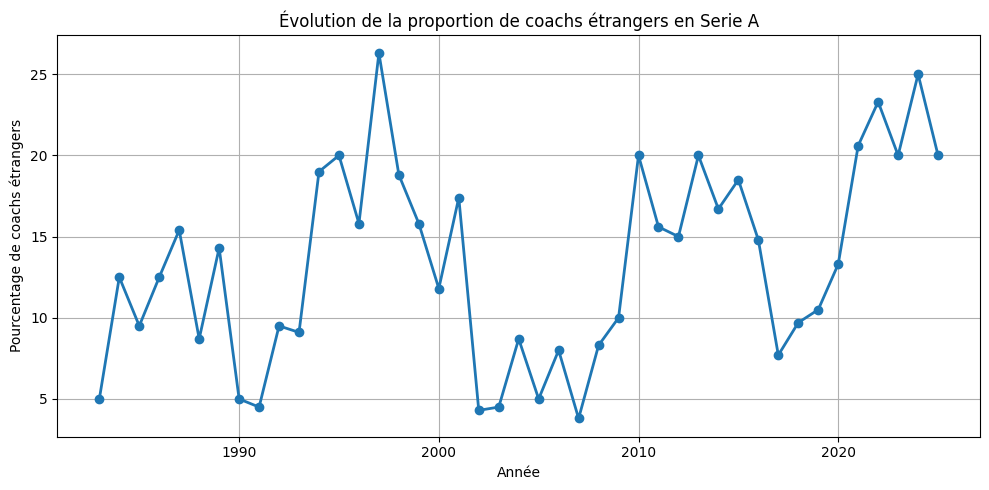

In [6]:
import matplotlib.pyplot as plt

# Tracé de l'évolution de la proportion de coachs étrangers
plt.figure(figsize=(10, 5))
plt.plot(summary.index, summary["% Foreign"], marker='o', linewidth=2)

plt.title("Évolution de la proportion de coachs étrangers en Serie A")
plt.xlabel("Année")
plt.ylabel("Pourcentage de coachs étrangers")
plt.grid(True)
plt.tight_layout()
plt.show()
